# OpenDP Library Exercise Solutions

You can work [here in Colab](https://colab.research.google.com/github/opendp/opendp/blob/ppai-notebook/ppai-exercise.ipynb), or download this notebook and edit 
locally.
Use `Shift+Enter` to execute a cell. 

In [120]:
%pip install opendp seaborn


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [121]:
import opendp.prelude as dp

Any constructors that have not completed the proof-writing and vetting process may still be accessed if you opt-in to "contrib".

[[Documentation]](https://github.com/opendp/opendp/discussions/304)

In [122]:
# TODO: enable "contrib"
dp.enable_features("contrib")

# (this assertion should pass)
assert "contrib" in dp.GLOBAL_FEATURES

## Exercise: Sydney Pedestrian Traffic Data

The Sydney Pedestrian Traffic data set logs the first sightings of an individual 
on Park Street, Bridge Street and Market Street, on February 3, 2024.
The data is based on true counts of hourly per-street pedestrian traffic,
but has additional synthetically-generated attributes: name, age and gender.

### 1. Privacy Unit

First, determine the privacy unit. Remember that:
* the data only spans one day
* only the first sighting of an individual is logged, per-street
* there are only three streets

In [123]:
privacy_unit = dp.unit_of(contributions=3)

### 2. Privacy Loss

Create a privacy loss budget of $\epsilon = 1.0$.

In [124]:
privacy_loss = dp.loss_of(epsilon=1000.)

### 3. Public Information

Taken from the data description.

In [125]:
col_names = ["Street", "Hour", "First Name", "Last Name", "Age", "Gender"]
street_names = ["Park Street", "Bridge Street", "Market Street"]

### 4. Mediate Access
Initialize the context for our analysis: data, privacy unit and privacy loss.

In [126]:
context = dp.Context.compositor(
    data=open("Sydney_Synth_Pedestrian_Counts_2024_2_3.csv").read(),
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=10,
)

### 5.a Per-Street Counts

Compute a DP count of the number of sightings on Bridge Street:

In [127]:
bridge_count_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .df_is_equal("Street", "Bridge Street")
    .subset_by("Street", keep_columns=["First Name"])
    .select_column("First Name", str)
    # TODO
    .count()
    .laplace()
)
bridge_count_query.release()

3819

Release DP counts of the other two streets.

The following release counts sightings on all three streets using only one query, 
by taking advantage of parallel composition:

In [128]:
count_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .select_column("Street", str)
    .count_by_categories(street_names, null_category=False)
    .laplace()
)
street_counts = count_query.release()
street_counts

[33794, 3819, 18758]

### 5.b Distribution of Pedestrians Per-Hour

Visualize how busy downtown Sydney is over the day.
Might collecting data by first sighting skew the data?

In [129]:
hours = list(range(24))
hourly_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .select_column("Hour", str)
    .cast_default(int)
    .count_by_categories(hours, null_category=False)
    .laplace()
)
hourly_sightings = hourly_query.release()
print(hourly_sightings)

[1783, 1333, 1349, 1126, 591, 239, 397, 701, 1030, 1900, 2795, 3773, 4404, 4481, 5022, 4867, 4918, 4086, 3124, 2755, 2068, 1785, 1087, 758]


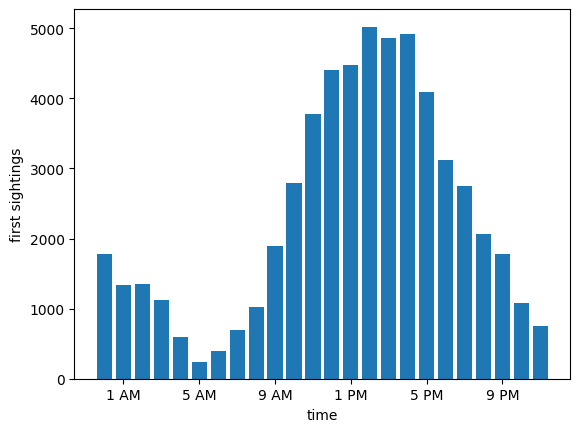

In [130]:
import matplotlib.pyplot as plt


def fmt(hour):
    return f"{int(hour) % 12} {'P' if int(hour) > 11 else 'A'}M"


plt.bar(list(map(fmt, hours)), hourly_sightings)
plt.xticks(range(1, 25, 4))

plt.xlabel("time")
plt.ylabel("first sightings");

### 5.c Park Street Ages Analysis

In this exercise, you'll compute the mean and variance of ages on Park Street.
Start preparing a query that preprocesses the data to a vector of ages.
The query should transform the data to be bounded and have known size.

In [131]:
q_park_street_ages = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .df_is_equal("Street", "Park Street")
    .subset_by("Street", keep_columns=["Age"])
    .select_column("Age", str)
    .cast_default(float)
    .clamp((0., 100.))
    .resize(size=street_counts[0], constant=42.)
)

Now submit queries to find the mean and variance.

In [132]:
q_park_mean_age = q_park_street_ages.mean().laplace()
q_park_mean_age.release()

41.597419777638024

In [133]:
q_park_mean_age = q_park_street_ages.variance().laplace()
q_park_mean_age.release()

190.35584901347798

### 5.c Upper Quartile of Ages on Market Street

Estimate the 75th percentile of the age of individuals on Market Street.

In [134]:
quantile_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .df_is_equal("Street", "Market Street")
    .subset_by("Street", keep_columns=["Age"])
    .select_column("Age", str)
    .cast_default(int)
    .quantile_score_candidates(list(range(100)), alpha=.75)
    .report_noisy_max_gumbel(optimize="min")
)
quantile_query.release()

53

### 5.d Sparse Histogram of Names

When dealing with data that has an unknown domain, the keys themselves are private information.
One approach used to privately release histograms on unknown key sets is to only release keys with large counts:
that is, only release keys that many people have contributed to, and thus remain stable across all neighboring datasets.
Another approach, used below, is to privatize a low-dimensional projection.

In [135]:
quantile_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .df_is_equal("Street", "Park Street")
    .subset_by("Street", keep_columns=["First Name"])
    .select_column("First Name", str)
    .count_by(MO=dp.L1Distance[int])
    .alp_queryable(scale=10.025, total_limit=sum(street_counts), value_limit=1000)
)
qbl = quantile_query.release()

This mechanism releases a queryable containing a differentially private, hash-based representation of the counts of all possible names.

As you would expect, the most common names have a relatively high number of observations.
Names that you would expect to be less common have lower counts.

In [136]:
qbl("Michael"), qbl("James"), qbl("Sharon"), qbl("Lancelot")

(782.0448877805486, 500.74812967581045, 82.5935162094763, 0.0)

Lancelot would likely not be observed in the data, so you would expect the true count to be near zero.